In [1]:
import numpy as np
import pandas as pd
import pickle
from glob import glob
import gzip
from tqdm.notebook import tqdm
from haversine import haversine

# Preprocess Data (Fwy 405 N)
Creates a simplified data set that will be good for model testing.  
Selects only stations on Fwy 405 N (the main freeway in LA)  
Creates an adjacency matrix for these stations only and a concatenated csv with 3 months of speed data   
Files are stored in `/data/processed/fwy-405-n/`

### Setup

In [2]:
# read station metadata
meta = pd.read_csv('../data/pems/d07_text_meta_2021_10_20.txt', sep='\t')
meta = meta[['ID', 'Fwy', 'Dir', 'District', 'County', 'City', 'State_PM', 'Abs_PM',
             'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name']]

meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.43,ML,3,PHOEBE
1,715900,5,S,7,37,40032.0,1.06,117.630,33.882892,-118.026822,NaN,OR,1,VALLEY VIEW
2,715901,5,N,7,37,40032.0,1.11,117.743,33.883400,-118.027451,NaN,OR,1,VALLEY VIEW
3,715903,5,N,7,37,69154.0,1.56,118.193,33.886992,-118.034125,NaN,OR,1,ALONDRA
4,715904,5,S,7,37,69154.0,2.27,118.840,33.892489,-118.044573,NaN,OR,1,CARMENITA


In [3]:
# read station data helper function
data_dict = pd.read_csv('../data/pems/station_dict.csv', names=['Feature', 'Description', 'Unit']).iloc[1:].reset_index(drop=True)
colnames = data_dict['Feature'].values.tolist()
colnames_subset = ['Timestamp', 'Station', 'Station Length', 'Samples', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
                'Lane N Samples', 'Lane N Flow', 'Lane N Avg Occ', 'Lane N Avg Speed', 'Lane N Observed']

FILES = glob('../data/pems/*.gz')

def read_station_data(file_no):

    with gzip.open(FILES[file_no]) as f:
        df = pd.read_csv(f, index_col=False, names=colnames)[colnames_subset]

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    return df

### Filter Data
Only use sensors along Fwy 405 N route  
Build adjacency matrix using absolute postmile

In [4]:
# select only Fwy 405 N mainlines
meta = meta[(meta['Fwy'] == 405) & (meta['Type'] == 'ML') & (meta['Dir'] == 'N')]
meta = meta.sort_values('Abs_PM')
meta = meta.reset_index(drop=True)
meta.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name
0,771826,405,N,7,37,43000.0,.11,24.058,33.787054,-118.094505,0.303,ML,4,N. OF 605
1,717696,405,N,7,37,43000.0,.6,24.548,33.791829,-118.100867,0.495,ML,4,STUDEBAKER
2,718219,405,N,7,37,43000.0,1.1,25.048,33.796718,-118.107431,0.565,ML,4,PALO VERDE
3,717701,405,N,7,37,43000.0,1.73,25.678,33.802431,-118.115997,0.675,ML,4,WOODRUFF
4,717703,405,N,7,37,43000.0,2.45,26.398,33.802865,-118.128314,0.505,ML,4,BELLFLOWER 2


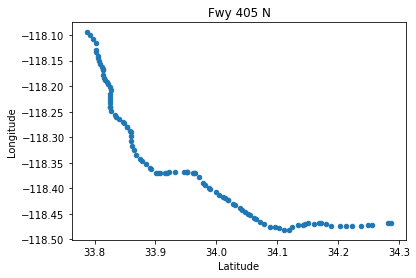

In [5]:
# show route
p = meta.plot.scatter('Latitude', 'Longitude', title='Fwy 405 N')

In [6]:
# build adjacency matrix
# we build many different types here
# choose which one is saved at the end of the notebook

stations = np.array(meta['ID'])

# build station-ind mapper
station_ind_mapper = {station: i for i, station in enumerate(stations)}

# haversine distance connecting all stations
mat_haversine = np.array( [[haversine((float(row1['Latitude']), float(row1['Longitude'])), \
                                      (float(row2['Latitude']), float(row2['Longitude']))) \
                           for i1, row1 in meta.iterrows()] for i2, row2 in meta.iterrows()] )

# postmile distance connecting all stations
mat_all = np.array( [[abs(y-x) for y in meta['Abs_PM']] for x in meta['Abs_PM']] )

# distance connecting only upstream stations; uses manhattan as distance metric
mat_upstream = np.array( [[y-x if y-x>=0 else np.inf for y in meta['Abs_PM']] for x in meta['Abs_PM']] )

# distance connecting only adjacent stations; uses manhattan as distance metric
mat_adjacent = np.array( [[abs(x-y) if abs(i-j)<=1 else np.inf for (i,y) in enumerate(meta['Abs_PM'])] \
                                                         for (j,x) in enumerate(meta['Abs_PM'])] )

print(mat_all)

[[ 0.     0.49   0.99  ... 45.914 47.654 48.014]
 [ 0.49   0.     0.5   ... 45.424 47.164 47.524]
 [ 0.99   0.5    0.    ... 44.924 46.664 47.024]
 ...
 [45.914 45.424 44.924 ...  0.     1.74   2.1  ]
 [47.654 47.164 46.664 ...  1.74   0.     0.36 ]
 [48.014 47.524 47.024 ...  2.1    0.36   0.   ]]


### Extract Station Data
Get a single dataframe with time and speed for the selected sensors

In [10]:
# function to extract time x speed dataframe for selected stations
def get_station_data(start_day, end_day):
    data = []
    for i in tqdm( range(start_day, end_day) ):
        df = read_station_data(i)
        df = df[df['Station'].isin(meta['ID'])]
        df = df[['Timestamp', 'Station', 'Avg Speed']]
        df.columns = ['Time', 'Station', 'Speed']
        data.append(df)
    
    return pd.concat(data).reset_index(drop=True)

# select May - July
df = get_station_data(120, 212)
df

,Time,Station,Speed
0,2021-02-04 00:00:00,716632,71.7
1,2021-02-04 00:00:00,716659,71.9
2,2021-02-04 00:00:00,716663,70.5
3,2021-02-04 00:00:00,716670,68.0
4,2021-02-04 00:00:00,716689,65.2
...,...,...,...
2785006,2021-01-20 23:55:00,775261,69.6
2785007,2021-01-20 23:55:00,775936,64.5
2785008,2021-01-20 23:55:00,776739,68.5
2785009,2021-01-20 23:55:00,776844,66.5


In [11]:
# create pivoted df with column for each station
pivoted_df = df.pivot_table(values='Speed', index='Time', columns='Station')
pivoted_df.index.name = None
pivoted_df.columns.name = None
pivoted_df.index = pd.to_datetime(pivoted_df.index)
pivoted_df = pivoted_df[stations]
pivoted_df

,771826,717696,718219,717701,717703,718227,717706,717709,716632,771845,...,767351,717819,717823,767367,717825,717827,771808,771767,772011,772024
2021-01-01 00:00:00,69.2,68.6,69.9,70.8,68.7,70.5,72.6,72.2,71.4,69.2,...,64.9,68.7,68.1,67.7,68.1,67.8,64.9,71.8,69.3,66.8
2021-01-01 00:05:00,70.4,68.2,67.9,69.4,66.9,70.6,72.2,73.7,71.5,69.4,...,64.9,69.6,68.7,68.4,69.4,68.4,63.8,68.8,69.4,65.0
2021-01-01 00:10:00,70.1,69.3,69.4,70.5,67.4,70.7,70.5,73.3,71.6,70.0,...,65.2,69.2,68.2,67.8,68.7,67.5,65.0,67.5,69.8,67.1
2021-01-01 00:15:00,69.9,68.7,69.1,69.9,70.5,70.4,71.9,75.4,71.6,69.8,...,64.7,69.4,68.4,68.3,69.9,68.8,67.0,72.8,69.0,66.3
2021-01-01 00:20:00,70.3,69.5,68.9,70.6,59.8,71.0,72.5,74.5,71.9,70.8,...,65.0,70.3,68.9,68.7,69.9,68.1,69.8,72.6,69.1,65.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28 23:35:00,68.8,68.8,68.3,66.6,68.4,76.2,66.5,66.5,70.3,69.2,...,61.6,64.4,62.4,62.4,67.5,68.3,68.3,68.7,68.5,66.3
2021-12-28 23:40:00,69.8,68.3,67.4,67.4,67.8,74.0,66.5,72.5,70.9,68.6,...,62.4,67.6,64.4,63.4,67.8,68.4,68.4,68.8,68.7,67.7
2021-12-28 23:45:00,69.2,68.5,67.5,67.2,68.4,73.6,72.0,74.1,71.9,68.8,...,63.6,67.8,66.5,65.1,69.3,68.5,68.5,68.8,68.9,65.8
2021-12-28 23:50:00,68.4,69.4,68.7,66.3,68.1,75.1,69.2,74.0,71.3,69.7,...,61.4,67.2,64.2,63.5,69.3,68.3,68.3,68.7,69.2,66.8


In [12]:
# identify missing values
print('missing values: ', pivoted_df.isna().sum().sum())

pivoted_df[ [x.isna().any() for x in pivoted_df.iloc] ]

missing values:  219


,771826,717696,718219,717701,717703,718227,717706,717709,716632,771845,...,767351,717819,717823,767367,717825,717827,771808,771767,772011,772024
2021-02-18 18:40:00,NaN,64.4,64.4,64.5,NaN,65.0,64.0,NaN,65.2,65.1,...,NaN,NaN,NaN,35.2,NaN,NaN,NaN,57.9,NaN,64.7
2021-03-09 15:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-13 20:05:00,NaN,66.8,65.1,67.9,66.2,70.6,NaN,NaN,69.8,NaN,...,NaN,NaN,65.7,NaN,64.8,NaN,NaN,NaN,65.8,NaN


In [13]:
# fill missing values with linear interpolation
pivoted_df = pivoted_df.interpolate(method='linear', limit_direction='forward', axis=0)

### Save Data

location: `data/processed/fwy_405_n_ds/`

In [14]:
# write station metadata file
meta.to_csv('../data/processed/fwy_405_n_ds/meta.csv', index=False)

# save adj_mat 
with open('../data/processed/fwy_405_n_ds/adj_mat.dat', 'wb')  as f:
    pickle.dump(mat_haversine, f)

# save mapper for adj_mat index to station ID
with open('../data/processed/fwy_405_n_ds/adj_mat_ind_station_mapper.dat', 'wb') as f:
    pickle.dump({station_ind_mapper[station]: station for station in station_ind_mapper}, f)

# save full speed df concatenated for all days in 2021
with open('../data/processed/fwy_405_n_ds/speeds.dat', 'wb')  as f:
    pickle.dump(pivoted_df, f)